# MedBot

### Miniprojet dans le cadre de l'UE "Réseaux de neurones" - M2 AMIS

GODET Chloé et GROSJACQUES Marwane
___________________________________

## Pourquoi un chatbot médical ? 

Un chatbot médical pourrait être un outil précieux pour des patients. En effet, le fait que cet outil soit disponible 7j/7 et 24h/24 permettraient à ceux qui souhaitent poser leurs questions d'avoir un interlocuteur toujours disponible. De plus, pour les personnes vivant dans des zones isolées (dans les déserts médicaux notamment) ou ayant des difficultés à se déplacer, le chatbot peut représenter un premier contact pour obtenir des informations ou un premier avis avant de consulter un professionnel.

Un chatbot peut analyser les réponses des utilisateurs et fournir des recommandations adaptées comme suggérer une consultation avec un spécialiste ou encore orienter vers un service d'urgence en cas de symptômes graves.
Cependant, un chatbot médical ne remplace en aucun cas un médecin. Les diagnostics, traitements et décisions médicales doivent toujours être confiés à des professionnels de santé qualifiés.

## Notre objectif

Nous avons décidé de réaliser un chatbot médical (**MedBot**). Au vu de nos connaissances, du temps dont on dispose et surtout de nos ressources actuelles, nous savons que nous ne pouvons pas réaliser un chatbot réellement performant.

L'objectif était, pour nous, une version très simple : pouvoir lui donner un/des symptôme(s) et qu'il nous donne un diagnostic possible.
Nous parlerons des améliorations possibles que nous aurions aimé implémenter à la fin de ce notebook.
_________________________________

## Importer le dataset

Nous avons travaillé sur Google Colab tout au long de ce projet afin de bénéficier du GPU que propose le site. En effet, lors de l'entraînement du modèle, l'utilisation seule du CPU n'était pas assez performante.

La cellule suivante permet d'importer le dataset dans l'environnement de Google Colab.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving dataset.csv to dataset.csv
User uploaded file "dataset.csv" with length 30664 bytes


# Les librairies

Voici toutes les librairies que nous avons utilisées.

In [1]:
import torch                    # module principal pour notre réseau de neurones
import math                     # calcul du log pour le positional encoding
import pickle                   # sauvegarde et chargement du tokenizer
import pandas as pd             # lecture du dataset
import matplotlib.pyplot as plt # dessine la courbe des epochs

# Le modèle

Comme nous sommes curieux et que nous aimons comprendre dans sa globalité ce qu'on utilise, nous avons choisis d'implémenter notre modèle et de ne pas utiliser de modèle pré-entraîné. Nous avons utilisé le transformer de pytorch, mais nous avons réalisé notre propre tokenization, notre positionnal encoding et nous avons généré des tokens du chatbot. Nous expliquerons cela dans la suite.

In [50]:
D_MODEL = 64

`D_MODEL` est la dimension de notre modèle, c'est à dire le nombre de tokens que nous pouvons donner en input à notre modèle.

## Le tokenizer

Nous avons décidé de faire notre propre tokenizer qui sera rempli avec les mots de notre dataset.
Il est composé de 4 tokens spéciaux :
- **PAD**, le padding
- **CLS**, le début de la phrase
- **SEP**, la fin de la phrase
- **UNK**, lorsque le mot n'est pas connu et ne doit pas être ajouté au tokenizer

Ensuite, chaque mot encodé avec le tokenizer permet de le remplir. En effet, si un mot n'est pas encore reconnu par le tokenizer, nous lui attribuons un nouveau token qui sera redonné à chaque apparition de ce mot.

Le tokenizer permet d'**encoder** une phrase et de **décoder** une suite de tokens.

Nous avons aussi implémenté la sauvegarde et le chargement du tokenizer afin de ne pas avoir à le reremplir à chaque fois.

In [7]:
class Tokenizer:
    pad_token_id = 0
    pad_token = "[PAD]"
    cls_token_id = 1
    cls_token = "[CLS]"
    sep_token_id = 2
    sep_token = "[SEP]"
    unk_token_id = 3
    unk_token = "[UNK]"
    special_tokens = [pad_token_id, cls_token_id, sep_token_id, unk_token_id]


    def __init__(self, filename=None):
        if filename:
            with open(filename, 'rb') as file:
                self.vocab = pickle.load(file)
            self.next_token_id = max(self.vocab.values()) + 1
            if len(self.vocab) != self.next_token_id:
                print("Token(s) manquant(s) dans le vocabulaire")
                exit(1)

        else:
            self.vocab = {
                    self.pad_token: self.pad_token_id,
                    self.cls_token: self.cls_token_id,
                    self.sep_token: self.sep_token_id,
                    self.unk_token: self.unk_token_id
            }
            self.next_token_id = 4

    def add_word(self, word):
        self.vocab[word] = self.next_token_id
        self.next_token_id += 1

    def get_word(self, token):
        if 0 <= token and token < self.next_token_id:
            return list(self.vocab.keys())[list(self.vocab.values()).index(token)]
        else:
            exit(1)

    def vocab_size(self):
        return len(self.vocab)

    def encode(self, text, size=D_MODEL, should_extend=False):
        words = text.strip().lower().split(' ')
        tokens = [self.cls_token_id]
        for word in words:
            if word in self.vocab.keys():
                tokens.append(self.vocab[word])
            elif should_extend:
                self.add_word(word)
                tokens.append(self.vocab[word])
            else:
                tokens.append(self.unk_token_id)

        tokens.append(self.sep_token_id)

        if len(tokens) > size: print("[WARNING] Phrase trop longue")
        while len(tokens) < size:
            tokens.append(self.pad_token_id)

        return tokens

    def decode(self, tokens, skip_special_tokens=False):
        if skip_special_tokens:
            words = [self.get_word(token) for token in tokens if token not in self.special_tokens]
        else:
            words = [self.get_word(token) for token in tokens]

        return " ".join(words)

    def save(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.vocab, file, protocol=pickle.HIGHEST_PROTOCOL)

## Positional Encoding

Pytorch ne propose pas de Positional Encoding, nous avons donc écrit notre propre Positional Encoding (celui vu en cours).

In [8]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=100, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # sin sur indices pairs
        pe[:, 1::2] = torch.cos(position * div_term)  # cos sur indices impairs

        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

## Notre modèle principal

In [9]:
class TransformerModel(torch.nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        self.transformer = torch.nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, batch_first=True)
        self.fc_out = torch.nn.Linear(d_model, vocab_size)
        self.src_pad_idx = None
        self.nhead = nhead

    def forward(self, src, tgt):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(tgt))
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        src_mask = (src == 0).unsqueeze(1).unsqueeze(2).expand(-1, self.nhead, D_MODEL, -1)
        src_mask = src_mask.reshape(src.size(0)*self.nhead, D_MODEL, D_MODEL)

        output = self.transformer(src_emb, tgt_emb, src_mask=src_mask, tgt_mask=tgt_mask)
        return self.fc_out(output)

In [16]:
torch.serialization.add_safe_globals([TransformerModel])

# Le dataset

Trouver un dataset médical complet est compliqué. Nous cherchions un dataset qui associe des symptômes à un diagnostic possible. Exemple : 
- les symptômes : forte fièvre, douleurs musculaires, frissons, fatigue
- la maladie possible : la grippe

Nous avons rapidement exclut de créer le dataset puisque cela nécessite soit de nombreuses connaissances en médecine, soit un temps très important pour chercher un ensemble de maladies possibles et lui associer "à la main" tous les symptômes les plus fréquents. 

Nous avons opté pour une sorte de mélange : 
- nous avons récupéré un [dataset](https://www.geeksforgeeks.org/talking-healthcare-chatbot-using-deep-learning/)
- nous avons ajouté des symptômes et des maladies à la main pour l'enrichir un petit peu

Notre dataset est "petit" : 
on a 124 maladies possibles, et pour chacune on a entre 3 et 11 symptômes ainsi que 2 ou 3 réponses possibles. 
Nous avons donc fait toutes les combinaisons possibles des symptômes avec les réponses correspondantes, et on obtient un peu plus de 2300 données.

Travailler avec un petit dataset a été un réel challenge, et si nous avions eu plus de temps, nous aurions aimé pouvoir l'enrichir encore davantage!

In [10]:
def load_dataset(filename, tokenizer):
    data = pd.read_csv(filename)

    dataset_src = []
    dataset_tgt = []


    for index, row in data.iterrows():
        row_patterns = [row[col] for col in row.index if "intents/patterns" in col and pd.notna(row[col])]
        row_responses = [row[col] for col in row.index if "intents/responses" in col and pd.notna(row[col])]

        for response in row_responses:
            for pattern in row_patterns:
                dataset_src.append(tokenizer.encode(pattern, should_extend=True))
                dataset_tgt.append(tokenizer.encode(response, should_extend=True))

            dataset_src.append(tokenizer.encode("i have "+" and ".join(row_patterns), should_extend=True))
            dataset_tgt.append(tokenizer.encode(response, should_extend=True))

    return torch.tensor(dataset_src), torch.tensor(dataset_tgt)

# Entrainement du modèle

On définit ensuite notre fonction d'apprentissage.

Nous avons opté pour 1000 epochs et un apprentissage par batch de taille 200 avec permutation aléatoire.

In [11]:
def train_model(model, dataset_src, dataset_tgt, vocab_size, pad_id):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 1000
    batch_size = 200


    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        permutation = torch.randperm(dataset_src.size()[0])

        for i in range(0, len(dataset_src), batch_size):
            indices = permutation[i:i+batch_size]
            src_batch = dataset_src[indices]
            tgt_batch = dataset_tgt[indices]

            decoder_input = tgt_batch[:, :-1]  # Entrée du décodeur (sans le dernier token)
            decoder_target = tgt_batch[:, 1:]  # Cible (sans le premier token)

            optimizer.zero_grad()
            output = model(src_batch, decoder_input)
            loss = criterion(output.view(-1, vocab_size), decoder_target.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataset_src)}")

On combine ensuite le tout pour que notre modèle apprenne avec notre dataset.

In [12]:
dataset_file = "./dataset.csv"

In [13]:
tokenizer = Tokenizer()
dataset_src, dataset_tgt = load_dataset(dataset_file, tokenizer)

In [ ]:
model = TransformerModel(tokenizer.vocab_size())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

dataset_src = dataset_src.to(device)
dataset_tgt = dataset_tgt.to(device)
model = model.to(device)

train_model(model, dataset_src, dataset_tgt, tokenizer.vocab_size(), tokenizer.pad_token_id)

**Voici la courbe d'apprentissage de notre modèle sur 1000 epochs.**

            0
0    0.032375
1    0.027359
2    0.022264
3    0.019253
4    0.017256
..        ...
995  0.000952
996  0.000945
997  0.000937
998  0.000926
999  0.000920

[1000 rows x 1 columns]


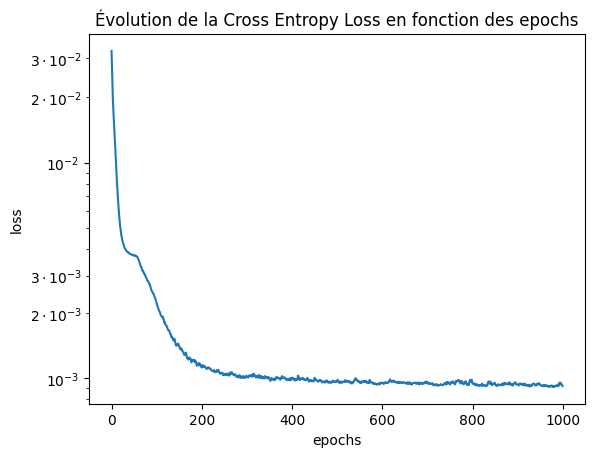

In [3]:
data = pd.read_csv("./teaching.txt", header=None)
print(data)
plt.yscale('logit')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Évolution de la Cross Entropy Loss en fonction des epochs")
plt.plot(data)
plt.show()

## Sauvegarde et chargement du modèle

In [14]:
torch.save(model, "medbot.pt")
tokenizer.save("tokenizer.pkl")

In [18]:
model = torch.load("medbot.pt", weights_only=False, map_location=torch.device('cpu'))
tokenizer = Tokenizer("tokenizer.pkl")


# Utilisation du modèle

La fonction `top_k_sampling` permet de choisir un token parmis les **k** meilleurs. Cela donne un aspect aléatoire à la phrase construite par le modèle.

Pour ce faire, nous prenons les k tokens avec le meilleur score. Nous transformons les scores en probabilité à l'aide de la fonction **softmax**. Nous tirons un token aléatoirement parmi les k en fonction de leur probabilité respective.

In [ ]:
def top_k_sampling(logits, k=3):
    top_k_probs, top_k_indices = torch.topk(torch.softmax(logits, dim=-1), k=k)
    idx = torch.multinomial(top_k_probs, num_samples=1)
    next_token = top_k_indices[idx]
    probability = top_k_probs[idx]
    return next_token, probability.item()

Nous pouvons alors générer une phrase avec notre modèle :
- La phrase source est transformée en tokens via notre tokenizer
- La phrase de sortie est initialisée avec le token **CLS** de notre tokenizer
- À chaque itération, nous donnons la phrase source et la phrase de sortie à notre modèle
- Un token est alors choisi aléatoirement avec `top_k_sampling` à partir des scores retournés par le modèle
- On ajoute ce token à la phrase de sortie
- Lorsque nous rencontrons le token **SEP** (ou que la taille maximale est atteinte), la phrase de sortie est finie et nous la décodons avec le tokenizer

In [53]:
def valid_tokens(tokens, tokenizer):
    for token in tokens:
        if token not in tokenizer.special_tokens:
            return True
    return False

def generate_answer(model, sentence, tokenizer, skip_special_tokens=False, max_len=64):
    model.to('cpu')
    model.eval()
    src_tokens = tokenizer.encode(sentence)
    if not valid_tokens(src_tokens, tokenizer):
      return "I did not understand."
    src = torch.tensor(src_tokens).unsqueeze(0)
    tgt = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0)

    first_word_probability = None
    for _ in range(max_len):
        output = model(src, tgt)
        next_token, probability = top_k_sampling(output[0, -1, :])
        if _ == 0: first_word_probability = probability
        tgt = torch.cat([tgt, torch.tensor([[next_token]])], dim=1)
        if next_token == tokenizer.sep_token_id:
            break

    return tokenizer.decode(tgt[0], skip_special_tokens=skip_special_tokens), first_word_probability

Ici, nous testons la génération de phrases en donner au modèle différents inputs. Pour chaque input, nous avons la phrase générée ainsi que la probabilité de son premier mot.

In [44]:
test_sentences = [
    "hello",
    "i have fever",
    "thank you"
]

for sentence in test_sentences:
    answer, probability = generate_answer(model, sentence, tokenizer)
    print("input :", sentence)
    print(f"({probability*100:3.1f}%)", answer)
    print()

input : hello
(31.4%) [CLS] hello! [SEP]

input : i have fever
(25.7%) [CLS] according to your symptoms you might have hepatitis a [SEP]

input : thank you
(28.2%) [CLS] talk to you later! [SEP]



# Le chabot interactif final
Pour finir, le chatbot peut être testé interactivement.

In [54]:
def chat_with_bot(model, tokenizer):
    print("[Start of conversation]")
    print("medbot: Hello, I am Medbot.")
    print("        You can stop the chat by typing 'quit', 'exit' or simply 'q'.")
    print("        Please tell me your symptoms.")
    while True:
        txt = input("user: ").strip()
        if txt in ["q", "quit", "exit"]: break
        answer, probability = generate_answer(model, txt, tokenizer, skip_special_tokens=True)
        print("medbot:", answer)
    print("[End of conversation]")

In [55]:
chat_with_bot(model, tokenizer)

[Start of conversation]
medbot: Hello, I am Medbot.
        You can stop the chat by typing 'quit', 'exit' or simply 'q'.
        Please tell me your symptoms.


user:  hello


medbot: hello, what can i do for you?


user:  i have difficulty swallowing


medbot: i suppose you have iron deficiency anaemia


user:  i also have jaw locking


medbot: have you been vaccinated against tetanus?


user:  Thank You, Goodbye


medbot: thank you to you too


user:  exit


[End of conversation]


# Améliorations

Nous avons pensé à quelques améliorations.

## **enrichissement du dataset**
Comme mentionné dans l'introduction, un des principaux problèmes que nous rencontrons est lié au fait que le dataset soit trop petit. Une des améliorations évidentes serait de l'enrichir considérablement, notamment en termes médicaux mais également avec des termes de la vie courante tels que les conjugaisons des mots, des formulations familières etc... afin que le chatbot puisse comprendre des phrases plus complexes.

## **la gestion d'une session**
Notre chatbot ne comprend actuellement qu'une phrase, et l'oublie une fois que l'utilisateur en saisit une autre. 
Notre idée aurait été d'avoir une mémoire lors d'une session de telle sorte que, tout ce qu'aurait dit un utilisateur entre sa connexion et le moment où il quitte, soit pris en compte lors de la réponse du chatbot.
Ainsi, l'utilisateur pourrait préciser ses symptômes au fur et à mesure de la discussion, et le chatbot pourrait ajuster ses réponses.

## **la confiance du modèle**
Aujourd'hui, notre modèle répond, quelque soit son niveau de confiance. 
On note deux sortes de cas :

**Problème 1 :** l'utilisateur entre un symptôme qui est commun à plusieurs maladies : le chatbot donnera un diagnostic de maladie qui contient ce symptôme.  
**Amélioration :** idéalement, s'il ne sait pas se décider, le chatbot devrait demander à l'utilisateur de lui donner d'autres symptômes afin d'affiner son diagnostic et pouvoir répondre avec un certain degré de confiance

**Problème 2 :** lorsque l'utilisateur donne une phrase qui contient des tokens inconnus associés à des tokens connus, le chatbot répondra quelque chose de sûrement incohérent. Par exemple, si l'utilisateur dit "I have a cat", le chatbot reconnaîtra "I have" puisque cela fait partit de son vocabulaire, mais il ne connaît pas le "a cat". Malheureusement, pour le moment, le chatbot peut répondre que vous êtes probablement atteint d'un cancer.  
**Amélioration :** il faudrait que notre modèle arrive à gérer ce genre de cas, et puisse fournir une réponse adaptée (soit il ne comprend pas la phrase et demande des précisions, soit informe qu'il ne comprend pas, soit arrive à extraire les informations pertinentes et si elles sont suffisantes, donne une réponse cohérente).   

Toutefois, si le chatbot ne reconnaît aucun mot, il informera l'utilisateur qu'il n'a pas compris sa phrase.

## **amélioration du tokenizer**
Cela aurait été bien que le tokenizer fasse de la correction de mot. 
Si je dis "bomjour", il devrait corriger pour donner le token correspondant à "bonjour" et à ne pas le classer comme inconnu. 

## **changement des paramètres (nombre de têtes, layers...)**
Nous avons testés plusieurs combinaisons, mais au vu des temps d'apprentissage et parfois de résultats non concluants, nous sommes restés sur les valeurs actuelles.

# Conclusion

Bien que nos ressources (en termes de GPU et de nombre de données) soient limitées, nous sommes contents d'avoir réussit à entraîner notre premier modèle et de pouvoir échanger avec un chatbot.
Ce projet nous a permis de mieux comprendre le Transformer, bien que vu en cours, et de saisir l'importance de chaque étape (tokenisation, embedding etc...). 
Nous sommes presque déçus que le projet ne dure pas plus longtemps car nous trouvons celui-ci ludique et intéressant!

In [35]:
print("medbot:", generate_answer(model, "Bye", tokenizer, skip_special_tokens=True)[0])

medbot: goodbye!
